In [216]:
import cellbell
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import psycopg2


with open('config.json') as f:
    conf = json.load(f)

# Data Collection & Merging

In [6]:
#Trying the database route
conn_str = "host={} dbname={} user={} password={}".format(conf['host'],conf['database'], conf['user'], conf['passw'])
conn = psycopg2.connect(conn_str)

In [7]:
plays = pd.read_sql('select * from play_player ', con=conn)
games = pd.read_sql('select * from game ', con=conn)
players = pd.read_sql('select * from player ', con=conn)

In [8]:
#dropping non-grouping columns + defensive fields. Might create a defensive scoring dataframe later.
def_cols = []
for d in plays.columns.values.tolist():
    if d.startswith('defense'):
        def_cols.append(d)

def_cols.extend(('drive_id','play_id'))
plays_dropped = plays.drop(columns=def_cols)


In [9]:
#Aggregating stats to game-player level
plays_sum = plays_dropped.groupby(by=['gsis_id','player_id','team']).sum().reset_index()

In [40]:
#fixing inconsistent complete of name columns
def fix_names(row):
    """This function looks up the chain of various name columns to fix null column issues"""
    if not row['gsis_name']:
        if not row['full_name']:
            if not row['last_name']:
                    return None
            else:
                if not row['first_name']:
                    return row['first_name'][0]+'.'+row['last_name']
                else:
                    return row['last_name']
        else:
            return row['full_name']
    else:
        return row['gsis_name']

In [51]:
#Applying fix_names function from above to create a new column
players.loc[:,'name_fixed'] = players.apply(fix_names,axis=1)

In [52]:
#dropping extra name columns and other unneccessary columbs now
players_dropped = players[['name_fixed','player_id','position','years_pro','height','weight']]

In [53]:
#joining players to aggregated plays
pp = plays_sum.merge(players_dropped, on='player_id', how='left')

In [54]:
#dropping unnecessary columns from games
games_dropped = games[['gsis_id','start_time','week','day_of_week','season_year','season_type','home_team','away_team','home_score','away_score']]

In [140]:
#joining players-plays to games
ppg = pp.merge(games_dropped, on='gsis_id', how='left')

In [60]:
ppg.to_csv('/Users/ianbury/player-game-stats.csv')

# EDA

In [65]:
ppg[ppg['fumbles_forced']>0]

,gsis_id,player_id,team,fumbles_forced,fumbles_lost,fumbles_notforced,fumbles_oob,fumbles_rec,fumbles_rec_tds,fumbles_rec_yds,...,weight,start_time,week,day_of_week,season_year,season_type,home_team,away_team,home_score,away_score
19,2009080950,00-0021379,TEN,1,0,0,0,1,0,0,...,225.0,2009-08-09 17:00:00-07:00,0,Sunday,2009,Preseason,TEN,BUF,21,18
158,2009081350,00-0023443,ARI,1,0,0,0,0,0,0,...,206.0,2009-08-13 17:00:00-07:00,1,Thursday,2009,Preseason,PIT,ARI,20,10
386,2009081352,00-0026188,WAS,2,1,0,0,1,0,0,...,247.0,2009-08-13 16:30:00-07:00,1,Thursday,2009,Preseason,BAL,WAS,23,0
419,2009081352,00-0026932,BAL,1,0,0,0,0,0,0,...,212.0,2009-08-13 16:30:00-07:00,1,Thursday,2009,Preseason,BAL,WAS,23,0
573,2009081450,00-0024264,NYJ,1,1,0,0,0,0,0,...,220.0,2009-08-14 16:00:00-07:00,1,Friday,2009,Preseason,NYJ,STL,20,23
607,2009081450,00-0026253,NYJ,1,0,1,1,0,0,0,...,212.0,2009-08-14 16:00:00-07:00,1,Friday,2009,Preseason,NYJ,STL,20,23
608,2009081450,00-0026302,NYJ,1,0,0,0,0,0,0,...,221.0,2009-08-14 16:00:00-07:00,1,Friday,2009,Preseason,NYJ,STL,20,23
628,2009081450,00-0026973,STL,1,0,0,0,1,0,0,...,178.0,2009-08-14 16:00:00-07:00,1,Friday,2009,Preseason,NYJ,STL,20,23
668,2009081451,00-0024452,IND,1,0,0,1,0,0,0,...,186.0,2009-08-14 16:30:00-07:00,1,Friday,2009,Preseason,IND,MIN,3,13
759,2009081452,00-0022778,NO,1,1,0,0,0,0,0,...,230.0,2009-08-14 17:00:00-07:00,1,Friday,2009,Preseason,NO,CIN,17,7


# Translating Stats to Fantasy Points

In [62]:
#Might add a config file here to set your league's settings

In [122]:
#adding list of relevant columns to scoring
scoring_cols = ['fantasy_score',
                'fumbles_rec_tds',
                'fumbles_lost',
                'passing_int',
                'passing_yds',
                'passing_tds',
                'passing_twoptm',
                'receiving_rec',
                'receiving_tds',
                'receiving_twoptm',
                'receiving_yds',
                'rushing_yds',
                'rushing_tds',
                'rushing_twoptm',
                'kicking_rec_tds',
                'puntret_tds',
                    ]

In [102]:
#List of relevant non-scoring columns
feature_cols=['gsis_id',
 'player_id',
 'team',
 'name_fixed',
 'position',
 'years_pro',
 'height',
 'weight',
 'start_time',
 'week',
 'day_of_week',
 'season_year',
 'season_type',
 'home_team',
 'away_team',
 'home_score',
 'away_score']

In [150]:
def scoring(row):
    """This function take all the columns relevant for scoring and apply their point values, 
    resulting in a fantasy score for each player-game"""
    passing = row['passing_int']*(-1)+row['passing_yds']*0.04+row['passing_tds']*4+row['passing_twoptm']*2
    rushing = row['rushing_yds']*0.1+row['rushing_twoptm']*2+row['rushing_tds']*6
    receiving = row['receiving_twoptm']*2+row['receiving_tds']*6+row['receiving_yds']*0.1+row['receiving_rec']*0.5
    fumbles = row['fumbles_rec_tds']*6+row['fumbles_lost']*(-2)
    returns = row['kicking_rec_tds']*6+row['puntret_tds']*6
   
    score = passing+rushing+receiving+fumbles+returns
    

    return score

In [151]:
ppg['fantasy_score']=ppg.apply(scoring,axis=1)

In [200]:
#We already have day of week and week of schedule, so let's truncate start_time to only be game time HH:MM for early vs. late game as a feature
ppg[['start_time', 'home_team','away_team']].sample(n=15)
#You'd think the offset would match the home_team timezone but that doesn't look to be the case.

,start_time,home_team,away_team
192332,2017-08-24 16:30:00-07:00,JAX,CAR
111151,2013-11-17 13:05:00-08:00,MIA,SD
124242,2014-08-28 17:00:00-07:00,CLE,CHI
19858,2009-12-13 17:20:00-08:00,NYG,PHI
7446,2009-09-20 10:00:00-07:00,JAX,ARI
173039,2016-09-15 17:25:00-07:00,BUF,NYJ
188213,2017-01-01 10:00:00-08:00,NYJ,BUF
187060,2016-12-24 10:00:00-08:00,GB,MIN
84312,2012-10-25 17:20:00-07:00,MIN,TB
37145,2010-10-31 10:00:00-07:00,DET,WAS


In [198]:
#Let's see all the different positions we have in the set. 
ppg['position'].unique()

array(['UNK', 'QB', 'RB', 'DE', 'TE', 'DB', 'WR', 'DT', 'K', 'P', 'LB',
       'OT', 'OG', 'NT', 'C', 'LS', 'T', 'FB', 'CB', 'SAF', 'OLB', 'OL',
       'ILB'], dtype=object)

In [177]:
#Focusing on only offensive positions for now.
off_pos = ['QB','RB','TE','WR','FB']

In [181]:
#Creating a dict of dataframes of Fantasy scores and features by game-player by postion
pos_scores={}
for o in off_pos:
    pos_scores[o] = ppg[ppg['position']==o]
pos_scores['RB'] = pos_scores['RB'].append(pos_scores['QB'])
del pos_scores['FB']

In [259]:
#Can delete below here
QB_2017 = pos_scores['QB'][pos_scores['QB']['season_year']==2017].set_index(['week','season_year'])

In [258]:
QB_2017['fantasy_score']

week  season_year
0     2017            9.70
      2017            9.78
1     2017           14.22
      2017            1.92
      2017            2.76
      2017            1.88
      2017           15.56
      2017            0.60
      2017            0.20
      2017            8.90
      2017            2.72
      2017            1.40
      2017            2.04
      2017            5.54
      2017            4.90
      2017            9.08
      2017           -0.20
      2017            2.04
      2017            2.78
      2017            7.76
      2017           14.44
      2017            1.08
      2017            2.68
      2017            3.04
      2017            2.38
      2017           12.56
      2017            7.80
      2017            7.00
      2017            5.22
      2017            6.24
                     ...  
17    2017           10.82
      2017           17.58
      2017            5.16
      2017            8.70
      2017           20.44
1     2017

ValueError: setting an array element with a sequence.

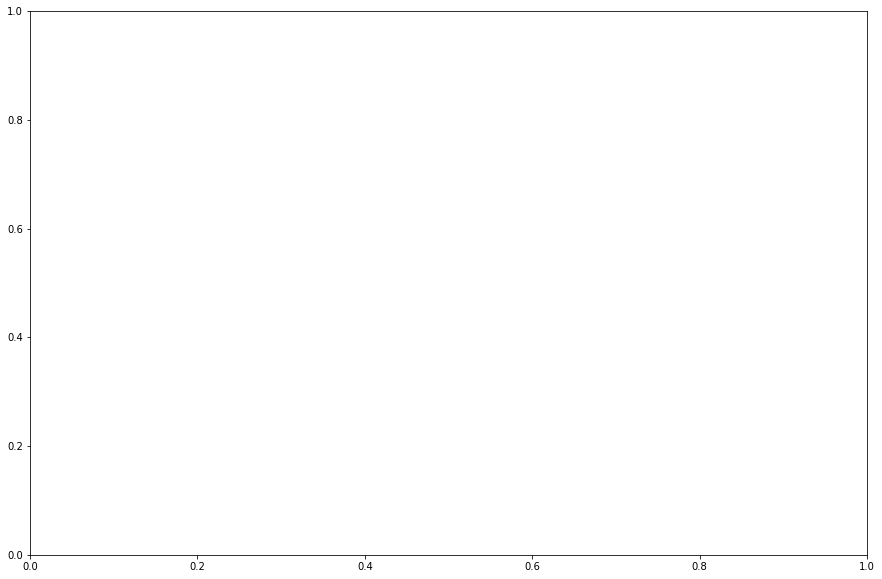

In [248]:
fig = plt.figure(figsize=(15,10))
for p in QB_2017['player_id'].unique()[:5]:
    plt.plot(QB_2017[QB_2017['player_id']==p]['fantasy_score'], label=QB_2017[QB_2017['player_id']==p]['name_fixed'].unique())
plt.legend(loc='right')


In [231]:
QB_2017['team'].nunique()

32